In [1]:
#imports
import pennylane as qml
from pennylane import numpy as np
import networkx as nx

In [2]:
n_nodes = 9

# graphs for training
graph_0 = [(0, 7), (1, 5), (1, 6), (1, 7), (2, 4), (2, 6), (2, 7), (3, 4), (3, 5), (3, 6), (4, 7), (5, 6), (5, 7), (6, 7), (6, 8), (7, 8)]
graph_1 = [(0, 4), (1, 4), (1, 5), (1, 7), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (3, 4), (3, 5), (4, 5), (4, 6), (4, 8), (5, 7)]

## grid graph
#graph_0 = [(0, 1), (0, 3), (1, 2), (1, 4), (2, 5), (3, 4), (3, 6), (4, 5), (4, 7), (5, 8), (6, 7), (7, 8)]
#graph_1 = [(0, 2), (0, 7), (1, 5), (1, 6), (1, 8), (2, 5), (2, 8), (3, 4), (3, 7), (4, 6), (4, 8), (7, 8)]
## cycle graph
#graph_0 = [(0, 1), (0, 8), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8)]
#graph_1 = [(0, 4), (0, 5), (1, 7), (1, 8), (2, 4), (2, 6), (3, 5), (3, 8), (6, 7)]

In [3]:
# translate graphs into vectors 
g = nx.from_edgelist(graph_0)
degree_centrality = nx.degree_centrality(g)
feature_vec_1 = []

for i in range(n_nodes):
    feature_vec_1.append(degree_centrality.get(i))

h = nx.from_edgelist(graph_1)
degree_centrality = nx.degree_centrality(h)
feature_vec_2 = []

for i in range(n_nodes):
    feature_vec_2.append(degree_centrality.get(i))

In [4]:
# variational layer
def layer(qubits, weights):
    for j in range(qubits):
        qml.RY(weights[0][j], wires=j)
        qml.RZ(weights[1][j], wires=j)
    for k in range(qubits):
        qml.CZ(wires=[k, (k+1) % qubits])

# inverse variational layer
def inverse_layer(qubits, weights):
    for i in range(qubits):
        qml.CZ(wires= [qubits-(i+1), (qubits-i) % qubits])
    for j in range(qubits):
        qml.RZ(weights[1][j], wires=j)
        qml.RY(weights[0][j], wires=j)

In [6]:
wires = range(n_nodes)
dev = qml.device('default.qubit', n_nodes)

# list circuit
@qml.qnode(dev, diff_method='backprop')
def circuit(weights, feature_vec):
    val = feature_vec
    qml.AngleEmbedding(val, wires)
    for i in range(int(np.sqrt(n_nodes))):
        layer(n_nodes, weights[i:i+2])
    return qml.state()
    #return qml.probs(wires)
    #return [qml.expval(qml.PauliZ(w)) for w in wires]
    #return qml.expval(qml.PauliZ(wires=[0])), qml.expval(qml.PauliZ(wires=[1]))

@qml.qnode(dev)
def inverse_circuit(weights, feature_vec1, feature_vec2):
    val1 = feature_vec1
    val2 = feature_vec2
    qml.AngleEmbedding(val1, wires)
    for i in range(int(np.sqrt(n_nodes))):
        layer(n_nodes, weights[i:i+2])
    inverse_weights = weights[::-1]
    for i in range(int(np.sqrt(n_nodes))):
        inverse_layer(n_nodes, inverse_weights[i:i+2])
    qml.AngleEmbedding(val2, wires)
    return qml.state()
    #return qml.expval(qml.PauliZ(wires=[0])), qml.expval(qml.PauliZ(wires=[1]))

In [7]:
# list architecture
weights = np.repeat(np.pi, 2*int(np.sqrt(n_nodes))*n_nodes)
weights = np.reshape(weights, (2*int(np.sqrt(n_nodes)), n_nodes))

a = circuit(weights, feature_vec_1)[0]
b = circuit(weights, feature_vec_2)[0]

## dot product equals 1 if equal vectors, dot product equals 0 if orthogonal vectors
fidelity = np.dot(a,b)
fidelity
print(qml.draw(circuit, expansion_strategy="device")(weights, feature_vec_1))
#print(qml.draw(inverse_circuit, expansion_strategy="device")(weights, feature_vec_1, feature_vec_2))

0: ──RX(0.12)──RY(3.14)──RZ(3.14)─╭●──────────────────────╭Z──RY(3.14)──RZ(3.14)─╭●───────────────
1: ──RX(0.38)──RY(3.14)──RZ(3.14)─╰Z─╭●───────────────────│───RY(3.14)──RZ(3.14)─╰Z─╭●────────────
2: ──RX(0.38)──RY(3.14)──RZ(3.14)────╰Z─╭●────────────────│───RY(3.14)──RZ(3.14)────╰Z─╭●─────────
3: ──RX(0.38)──RY(3.14)──RZ(3.14)───────╰Z─╭●─────────────│───RY(3.14)──RZ(3.14)───────╰Z─╭●──────
4: ──RX(0.38)──RY(3.14)──RZ(3.14)──────────╰Z─╭●──────────│───RY(3.14)──RZ(3.14)──────────╰Z─╭●───
5: ──RX(0.50)──RY(3.14)──RZ(3.14)─────────────╰Z─╭●───────│───RY(3.14)──RZ(3.14)─────────────╰Z─╭●
6: ──RX(0.75)──RY(3.14)──RZ(3.14)────────────────╰Z─╭●────│───RY(3.14)──RZ(3.14)────────────────╰Z
7: ──RX(0.88)──RY(3.14)──RZ(3.14)───────────────────╰Z─╭●─│───RY(3.14)──RZ(3.14)──────────────────
8: ──RX(0.25)──RY(3.14)──RZ(3.14)──────────────────────╰Z─╰●──RY(3.14)──RZ(3.14)──────────────────

────────╭Z──RY(3.14)──RZ(3.14)─╭●──────────────────────╭Z─┤  State
────────│───RY(3.14)──RZ(3.14)─╰Z─╭●─────

In [8]:
print(fidelity)

(1.0827964127856231e-13-6.03988734238021e-28j)


In [9]:
def costs(weights):
    fidelity = np.dot(circuit(weights, feature_vec_1)[0], circuit(weights, feature_vec_2)[0])
    return 1 - np.sqrt(np.real(fidelity)**2+np.imag(fidelity)**2) **2

In [10]:
np.random.seed(0)
weights_init = 0.01 * np.random.randn(2*int(np.sqrt(n_nodes)), n_nodes, requires_grad=True)
angle = [weights_init]

cost = [costs(weights_init)] 
opt = qml.GradientDescentOptimizer()
max_iterations = 1000
conv_tol = 1e-06

# ### circuit results in tensor array size 2^9, but only need value at position 0 
for n in range(max_iterations):
    weights_init, prev_cost = opt.step_and_cost(costs, weights_init)
    cost.append(prev_cost)
    angle.append(weights_init)

    conv = np.abs(cost[-1] - prev_cost)
    if n % 10 == 0:
        print(f"Step = {n},  Cost function = {cost[-1]:.8f} ")
#     # if conv <= conv_tol:
#     #     break
#qml.grad(costs)(weights_init)


Step = 0,  Cost function = 0.68380455 
Step = 10,  Cost function = 0.68364750 
Step = 20,  Cost function = 0.68352364 
Step = 30,  Cost function = 0.68342570 
Step = 40,  Cost function = 0.68334803 
Step = 50,  Cost function = 0.68328622 
Step = 60,  Cost function = 0.68323682 
Step = 70,  Cost function = 0.68319716 
Step = 80,  Cost function = 0.68316514 
Step = 90,  Cost function = 0.68313913 
Step = 100,  Cost function = 0.68311785 
Step = 110,  Cost function = 0.68310031 
Step = 120,  Cost function = 0.68308573 
Step = 130,  Cost function = 0.68307350 
Step = 140,  Cost function = 0.68306313 
Step = 150,  Cost function = 0.68305425 
Step = 160,  Cost function = 0.68304658 
Step = 170,  Cost function = 0.68303986 
Step = 180,  Cost function = 0.68303393 
Step = 190,  Cost function = 0.68302863 
Step = 200,  Cost function = 0.68302386 
Step = 210,  Cost function = 0.68301952 
Step = 220,  Cost function = 0.68301554 
Step = 230,  Cost function = 0.68301187 
Step = 240,  Cost function 

Text(0, 0.5, 'costs')

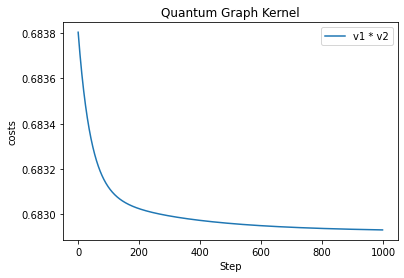

In [11]:
import matplotlib.pyplot as plt 
# plt.plot(cost[1:1000])
# plt.show()

t = np.arange(1000)
plt.figure()

plt.plot(cost[1:1000], label='v1 * v2')
plt.legend(loc = 'upper right')
plt.title('Quantum Graph Kernel')
ax = plt.gca()
#ax.set_ylim([0.0, 1])
#ax.fill_between(t, x, y = 0.5)
plt.xlabel("Step")
plt.ylabel("costs")

#plt.savefig('cost.svg', format='svg', dpi = 1200)

In [12]:
def sandwich_layer(qubits, weights):
    for j in range(int(qubits)):
        qml.RY(weights[0][j], wires=j)
        qml.RZ(weights[1][j], wires=j)
    for k in range(qubits):
        qml.CZ(wires=[k, (k+1) % qubits])

def inverse_sandwich_layer(qubits, weights):
    for i in range(qubits):
        qml.CZ(wires= [qubits-(i+1), (qubits-i) % qubits])
    for j in range(qubits):
        qml.RZ(weights[1][j], wires=j)
        qml.RY(weights[0][j], wires=j)

In [13]:
## sandwich architecture circuit
wires = range(int(np.sqrt(n_nodes)))
dev = qml.device('default.qubit', wires)

@qml.qnode(dev)
def sandwich_circuit(weights, val):
    qubits = int(np.sqrt(n_nodes))
    for i in range(qubits):
        qml.AngleEmbedding(val[i*qubits:(i*qubits)+qubits], wires)
        sandwich_layer(qubits, weights[i:i+2])

    return qml.state()

@qml.qnode(dev)
def inverse_sandwich_circuit(weights, feature_vec1, feature_vec2):
    val1 = feature_vec1
    val2 = feature_vec2
    
    qubits = int(np.sqrt(n_nodes))
    
    for i in range(qubits):
        qml.AngleEmbedding(val1[i*qubits:(i*qubits)+qubits], wires)
        sandwich_layer(qubits, weights[i:i+2])
    inverse_weights = weights[::-1]
    for i in range(qubits):
        inverse_sandwich_layer(qubits, inverse_weights[i:i+2])
        qml.AngleEmbedding(val2[(qubits-i-1)*qubits:((qubits-i-1)*qubits)+qubits], wires)

    return qml.state()
    #return qml.expval(qml.PauliZ(wires=[0])), qml.expval(qml.PauliZ(wires=[1]))



In [14]:
print(qml.draw(inverse_sandwich_circuit, expansion_strategy='device')(weights, feature_vec_1, feature_vec_2))

0: ──RX(0.12)──RY(3.14)──RZ(3.14)─╭●────╭Z──RX(0.38)──RY(3.14)──RZ(3.14)─╭●────╭Z──RX(0.75)
1: ──RX(0.38)──RY(3.14)──RZ(3.14)─╰Z─╭●─│───RX(0.38)──RY(3.14)──RZ(3.14)─╰Z─╭●─│───RX(0.88)
2: ──RX(0.38)──RY(3.14)──RZ(3.14)────╰Z─╰●──RX(0.50)──RY(3.14)──RZ(3.14)────╰Z─╰●──RX(0.25)

───RY(3.14)──RZ(3.14)─╭●────╭Z─╭Z────╭●─────────RZ(3.14)──RY(3.14)──RX(0.25)─╭Z────╭●───────
───RY(3.14)──RZ(3.14)─╰Z─╭●─│──│──╭●─╰Z─────────RZ(3.14)──RY(3.14)──RX(0.38)─│──╭●─╰Z───────
───RY(3.14)──RZ(3.14)────╰Z─╰●─╰●─╰Z──RZ(3.14)──RY(3.14)──RX(0.25)───────────╰●─╰Z──RZ(3.14)

───RZ(3.14)──RY(3.14)──RX(0.38)─╭Z────╭●─────────RZ(3.14)──RY(3.14)──RX(0.12)─┤  State
───RZ(3.14)──RY(3.14)──RX(0.88)─│──╭●─╰Z─────────RZ(3.14)──RY(3.14)──RX(0.38)─┤  State
───RY(3.14)──RX(0.62)───────────╰●─╰Z──RZ(3.14)──RY(3.14)──RX(0.75)───────────┤  State


In [15]:
# sandwich architecture
weights = np.repeat(np.pi, 18)
weights = np.reshape(weights, (6, 3))

a = sandwich_circuit(weights, feature_vec_1)[0]
b = sandwich_circuit(weights, feature_vec_2)[0]

## dot product equals 1 if equal vectors, dot product equals 0 if orthogonal vectors
fidelity = np.dot(a,b)
#print(qml.draw(sandwich_circuit, expansion_strategy="device")(weights, feature_vec_1))
print(qml.draw(inverse_sandwich_circuit, expansion_strategy='device')(weights, feature_vec_1, feature_vec_2))

0: ──RX(0.12)──RY(3.14)──RZ(3.14)─╭●────╭Z──RX(0.38)──RY(3.14)──RZ(3.14)─╭●────╭Z──RX(0.75)
1: ──RX(0.38)──RY(3.14)──RZ(3.14)─╰Z─╭●─│───RX(0.38)──RY(3.14)──RZ(3.14)─╰Z─╭●─│───RX(0.88)
2: ──RX(0.38)──RY(3.14)──RZ(3.14)────╰Z─╰●──RX(0.50)──RY(3.14)──RZ(3.14)────╰Z─╰●──RX(0.25)

───RY(3.14)──RZ(3.14)─╭●────╭Z─╭Z────╭●─────────RZ(3.14)──RY(3.14)──RX(0.25)─╭Z────╭●───────
───RY(3.14)──RZ(3.14)─╰Z─╭●─│──│──╭●─╰Z─────────RZ(3.14)──RY(3.14)──RX(0.38)─│──╭●─╰Z───────
───RY(3.14)──RZ(3.14)────╰Z─╰●─╰●─╰Z──RZ(3.14)──RY(3.14)──RX(0.25)───────────╰●─╰Z──RZ(3.14)

───RZ(3.14)──RY(3.14)──RX(0.38)─╭Z────╭●─────────RZ(3.14)──RY(3.14)──RX(0.12)─┤  State
───RZ(3.14)──RY(3.14)──RX(0.88)─│──╭●─╰Z─────────RZ(3.14)──RY(3.14)──RX(0.38)─┤  State
───RY(3.14)──RX(0.62)───────────╰●─╰Z──RZ(3.14)──RY(3.14)──RX(0.75)───────────┤  State


In [16]:
def sandwich_costs(weights):
    fidelity = np.dot(sandwich_circuit(weights, feature_vec_1)[0], sandwich_circuit(weights, feature_vec_2)[0])
    return 1 - np.sqrt(np.real(fidelity)**2+np.imag(fidelity)**2) **2

In [19]:
np.random.seed(0)
weights_init = 0.01 * np.random.randn(2*int(np.sqrt(n_nodes)), int(np.sqrt(n_nodes)), requires_grad=True)
angle = [weights_init]

cost = [sandwich_costs(weights_init)]
opt = qml.GradientDescentOptimizer()
max_iterations = 1000
conv_tol = 1e-06


### circuit results in tensor array size 2^9, but only need value at position 0 
for n in range(max_iterations):
    weights_init, prev_cost = opt.step_and_cost(sandwich_costs, weights_init)
    cost.append(prev_cost)
    angle.append(weights_init)

    conv = np.abs(cost[-1] - prev_cost)
    if n % 10 == 0:
        print(f"Step = {n},  Cost function = {cost[-1]:.8f} ")
    #if conv <= conv_tol:
    #    break

Step = 0,  Cost function = 0.97512641 
Step = 10,  Cost function = 0.97512531 
Step = 20,  Cost function = 0.97512420 
Step = 30,  Cost function = 0.97512309 
Step = 40,  Cost function = 0.97512197 
Step = 50,  Cost function = 0.97512084 
Step = 60,  Cost function = 0.97511970 
Step = 70,  Cost function = 0.97511856 
Step = 80,  Cost function = 0.97511741 
Step = 90,  Cost function = 0.97511625 
Step = 100,  Cost function = 0.97511508 
Step = 110,  Cost function = 0.97511389 
Step = 120,  Cost function = 0.97511270 
Step = 130,  Cost function = 0.97511150 
Step = 140,  Cost function = 0.97511028 
Step = 150,  Cost function = 0.97510905 
Step = 160,  Cost function = 0.97510781 
Step = 170,  Cost function = 0.97510656 
Step = 180,  Cost function = 0.97510529 
Step = 190,  Cost function = 0.97510401 
Step = 200,  Cost function = 0.97510271 
Step = 210,  Cost function = 0.97510139 
Step = 220,  Cost function = 0.97510006 
Step = 230,  Cost function = 0.97509871 
Step = 240,  Cost function 

Text(0, 0.5, 'costs')

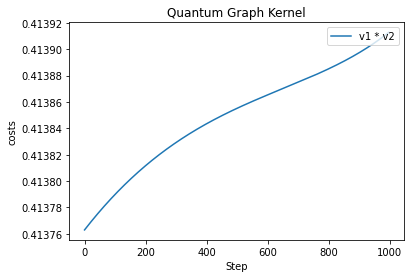

In [ ]:
t = np.arange(1000)
plt.figure()

plt.plot(cost[1:1000], label='v1 * v2')
plt.legend(loc = 'upper right')
plt.title('Quantum Graph Kernel')
ax = plt.gca()
#ax.set_ylim([0#0, 1])

plt.xlabel("Step")
plt.ylabel("costs")

#plt.savefig('ApproxRatioRandomTest01.svg', format='svg', dpi = 1200)